In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

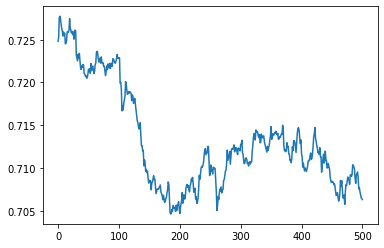

In [3]:
with open('data/data2/AUD_USD-1588780800-H1-10000.json') as f:
    data = json.load(f)
d = {r: [dic[r] for dic in data] for r in data[0]}
df = pd.DataFrame(d)
diff = list(df['O'].diff()[1:])
diff.append(np.nan)
# Label used for feature selection is when V_t=1 - V_t=0 > 0
df['d_O'] = diff
df['d_O_sign'] = df['d_O'] > 0
df_dev = df.loc[:500]
plt.plot(df_dev['O'])
plt.show()

In [12]:
class MACD:
    def __init__(self, capital):
        self.capital = capital
        self.hist = pd.DataFrame()

    def act(self, observation):
        """Given an observation, return an action.
        Input:
            observation - ndarray, shape=(1, d)
        Output:
            action - int, [-1, 0, 1] for sell, nothing, buy respectively
        """
        self.hist = self.hist.append(pd.Series(observation), ignore_index=True)
        self.hist['ema26'] = self.hist[0].ewm(span=26,
                                              min_periods=26,
                                              adjust=False).mean()
        self.hist['ema12'] = self.hist[0].ewm(span=12,
                                              min_periods=12,
                                              adjust=False).mean()
        self.hist['macd'] =  self.hist['ema12'] - self.hist['ema26']
        self.hist['macd_signal'] = self.hist['macd'].ewm(span=9,
                                                         min_periods=9,
                                                         adjust=False).mean()
        self.hist['diff'] = self.hist['macd'] - self.hist['macd_signal']
        self.hist['diff_lag'] = self.hist['diff'].shift(1)
        
        # action: 1 means buy, -1 means sell, 0 means do nothing
        self.hist['action'] = (np.sign(self.hist['diff']) - np.sign(self.hist['diff_lag'])) / 2
        self.hist['balance_change'] = -1 * self.hist['action'] * self.hist[0]
        self.hist['stock'] = self.hist['action'].cumsum()
        self.hist['balance'] = self.capital + self.hist['balance_change'].cumsum()
        
    def plot(self):
        fig, ax1 = plt.subplots()
        
        plt.title("Signals")
        ax1.plot(self.hist['macd'], label='macd')
        ax1.plot(self.hist['macd_signal'], label='macd_signal')
        ax1.plot(self.hist['diff'], label='macd_diff')
        ax1.set_ylabel("signals")
        plt.legend(loc='best')
        
        ax2 = ax1.twinx()
        ax2.plot(self.hist[0], 'r', label='price')
        ax2.set_ylabel("price")
        plt.show()
        
        plt.title("Balance")
        plt.plot(self.hist['balance'], '.', label='balance')
        plt.legend(loc='best')
        plt.show()
    
    def __repr__(self):
        return str(self.hist.iloc[-1])
    
    def run(self, X):
        for i, v in enumerate(X):
            self.act(v)

In [13]:
macd = MACD(capital=100)
for v in df['O'][:100]:
    macd.act(v)
# macd.act(df['O'][0])

C:\Users\notes\Anaconda3\envs\quant\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: invalid value encountered in sign
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [14]:
macd.hist

0     ema26     ema12      macd  macd_signal      diff  diff_lag  \
0   0.72482       NaN       NaN       NaN          NaN       NaN       NaN   
1   0.72524       NaN       NaN       NaN          NaN       NaN       NaN   
2   0.72760       NaN       NaN       NaN          NaN       NaN       NaN   
3   0.72774       NaN       NaN       NaN          NaN       NaN       NaN   
4   0.72748       NaN       NaN       NaN          NaN       NaN       NaN   
..      ...       ...       ...       ...          ...       ...       ...   
95  0.72246  0.722182  0.722271  0.000089     0.000026  0.000063  0.000067   
96  0.72278  0.722226  0.722349  0.000123     0.000045  0.000078  0.000063   
97  0.72326  0.722303  0.722489  0.000187     0.000073  0.000113  0.000078   
98  0.72286  0.722344  0.722546  0.000202     0.000099  0.000103  0.000113   
99  0.72281  0.722378  0.722587  0.000208     0.000121  0.000087  0.000103   

    action  balance_change  stock   balance  
0      NaN             NaN    NaN       NaN  
1      NaN             NaN    NaN       NaN  
2      NaN             NaN    NaN       NaN  
3      NaN             NaN    NaN       NaN  
4      NaN             NaN    NaN       NaN  
..     ...             ...    ...       ...  
95     0.0            -0.0    1.0  99.27812  
96     0.0            -0.0    1.0  99.27812  
97     0.0            -0.0    1.0  99.27812  
98     0.0            -0.0    1.0  99.27812  
99     0.0            -0.0    1.0  99.27812  

[100 rows x 11 columns]

C:\Users\notes\Anaconda3\envs\quant\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: invalid value encountered in sign
  result = getattr(ufunc, method)(*inputs, **kwargs)


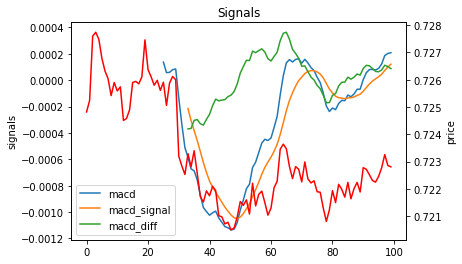

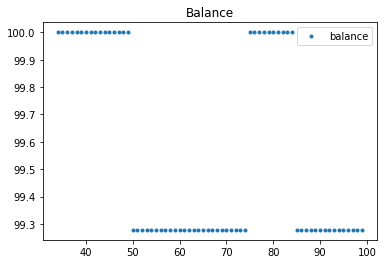

0                  0.722810
ema26              0.722378
ema12              0.722587
macd               0.000208
macd_signal        0.000121
diff               0.000087
diff_lag           0.000103
action             0.000000
balance_change    -0.000000
stock              1.000000
balance           99.278120
Name: 99, dtype: float64

In [15]:
macd = MACD(capital=100)
macd.run(df['O'][:100])
macd.plot()
macd

In [16]:
macd.hist['balance']

0          NaN
1          NaN
2          NaN
3          NaN
4          NaN
        ...   
95    99.27812
96    99.27812
97    99.27812
98    99.27812
99    99.27812
Name: balance, Length: 100, dtype: float64